In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import Pk_library as PKL
from copy import deepcopy
mpl.style.use('style.mcstyle')
os.chdir('..')


In [2]:
from cmass.bias.apply_hod import load_snapshot, populate_hod, load_params, parse_hod
from omegaconf import OmegaConf

In [8]:
lhid=0
simpath = f'/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/L1000-N128/{lhid}'
hpos, hvel, hmass, hmeta = load_snapshot(simpath, 0.666667)
cosmo = load_params(lhid, 'params/latin_hypercube_params.txt')
conf = OmegaConf.load(f'{simpath}/config.yaml')
model = 'zheng07'
conf.bias.hod.model = model
conf.bias.hod.seed = 0
conf = parse_hod(conf)
print(OmegaConf.to_yaml(conf))

meta:
  wdir: /home/mattho/git/ltu-cmass/data
  logdir: ${meta.wdir}/logs/
  cosmofile: ./params/latin_hypercube_params.txt
nbody:
  suite: quijotelike
  L: 1000
  'N': 128
  lhid: 0
  matchIC: true
  supersampling: 3
  save_particles: false
  save_transfer: true
  zi: 20
  zf: 0.5
  asave:
  - 0.6666666666666666
  transfer: CAMB
  order: 2
  B: 2
  N_steps: 32
  COLA: true
  mass_function: Watson_2013
  pinocchio_exec: /home/mattho/git/Pinocchio/src/pinocchio.x
  fastpm_exec: /home/mattho/git/fastpm/src/fastpm
  ai: 0.047619047619047616
  af: 0.6666666666666666
  quijote: true
  cosmo:
  - 0.1755
  - 0.06681
  - 0.7737
  - 0.8849
  - 0.6641
bias:
  halo:
    model: CHARM
    config_charm: config_v0.yaml
    base_suite: calib_1gpch_z0.5
    L: 1000
    'N': 128
    vel: CIC
  hod:
    seed: 0
    theta:
      logMmin: 13.03
      sigma_logM: 0.38
      logM0: 13.27
      logM1: 14.08
      alpha: 0.76
    logMmin: 13.0
    sigma_logM: 0.2
    logM0: 14.0
    logM1: 14.0
    alpha: 1.0


In [9]:
hmeta

{'concentration': array([3.48359938, 1.        , 3.6523424 , ..., 3.31467214, 2.18413597,
        2.48293599])}

### Generic test

In [21]:
L = 1000
N = 128
zf = 0.5
model = 'zheng07'
theta = conf.bias.hod.theta
seed = 0
mdef='vir'
hod = populate_hod(
    hpos, hvel, hmass, 
    cosmo, L, zf, 
    model, theta, 
    hmeta, 
    seed, 'vir'
)

gpos = np.array([hod['x'], hod['y'], hod['z']]).T
gvel = np.array([hod['vx'], hod['vy'], hod['vz']]).T
print(gpos.shape)

[16:44:26-INFO] Running populate_hod...
[16:44:26-INFO] Using saved halo concentration...
[16:44:27-INFO] Finished populate_hod... (0m0s)


(55938, 3)


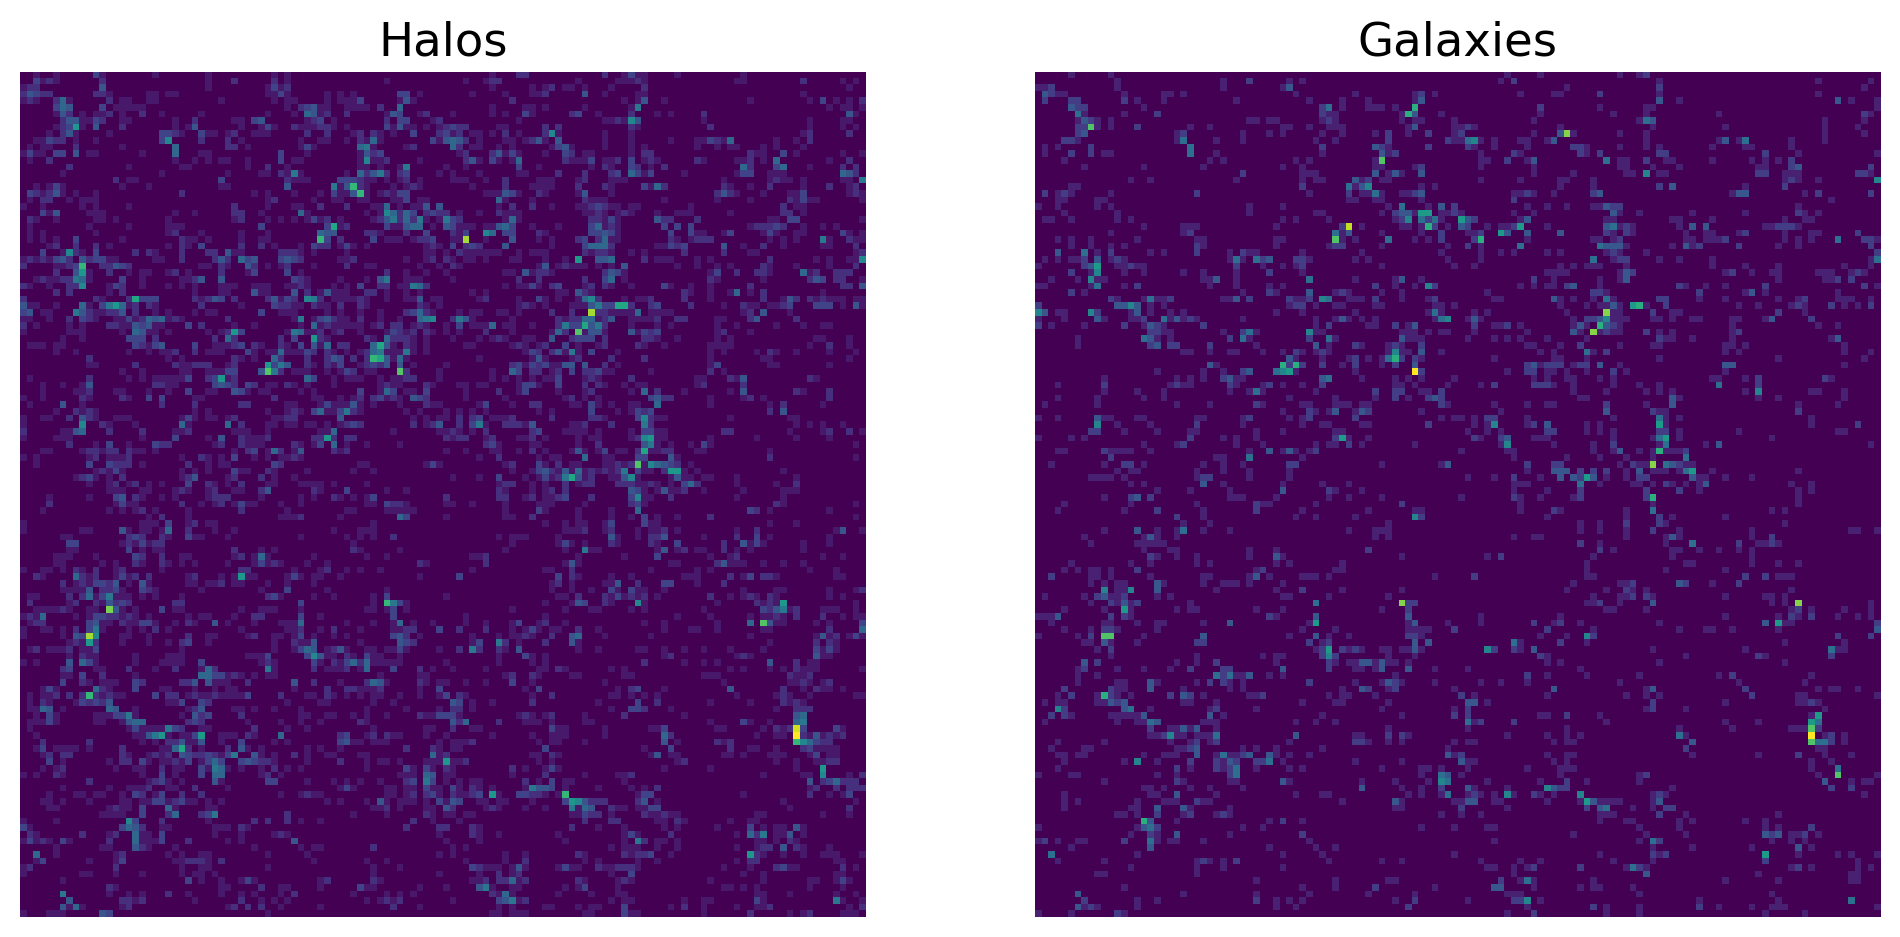

In [19]:
hhist, _ = np.histogramdd(
    hpos, bins=[128]*3, 
    range=[(0, L)]*3)

ghist, edges = np.histogramdd(
    gpos, bins=[128]*3, 
    range=[(0, L)]*3)

f, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(hhist[:10].mean(axis=0), origin='lower')
axs[0].set_title('Halos')
axs[1].imshow(ghist[:10].mean(axis=0), origin='lower')
axs[1].set_title('Galaxies')

for ax in axs:
    ax.axis('off')


Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds


Text(0.5, 1.0, 'Cross Power Spectrum')

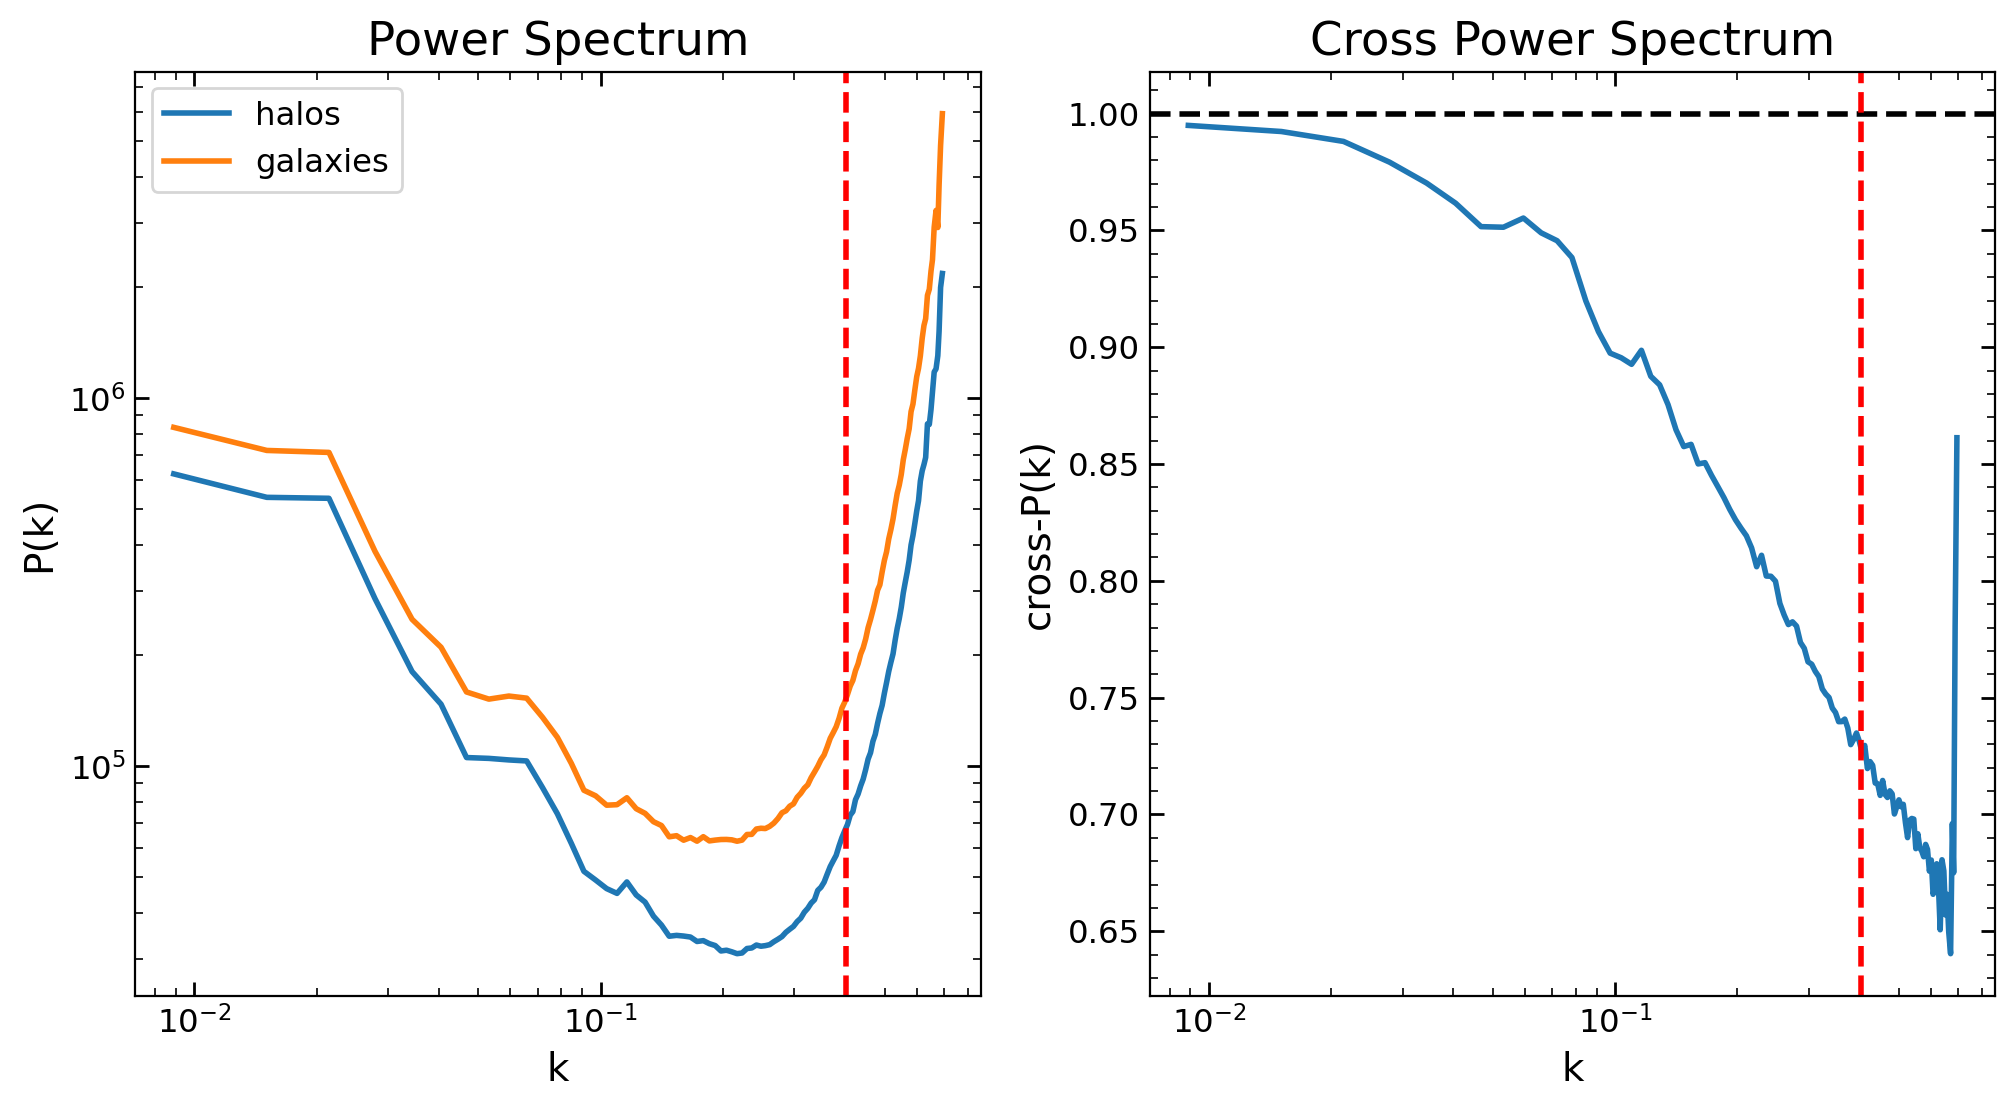

In [ ]:
hx = (hhist/np.mean(hhist) - 1).astype(np.float32)
gx = (ghist/np.mean(ghist) - 1).astype(np.float32)
XPk2 = PKL.XPk([hx, gx], BoxSize=L, axis=0, MAS=['CIC', 'CIC'], threads=1)

knyq = np.pi*N/L

f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.plot(XPk.k3D, XPk.Pk[:, 0, 0], label='halos')
ax.plot(XPk.k3D, XPk.Pk[:,0,1], label='galaxies')
ax.axvline(knyq, color='r', ls='--')
ax.set(xlabel='k', ylabel='P(k)')
ax.legend()
ax.loglog()
ax.set_title('Power Spectrum')

ax = axs[1]
ax.axhline(1, color='k', ls='--')
ax.plot(XPk.k3D, XPk.XPk[:,0,0]/np.sqrt((XPk.Pk[:, 0, 0]*XPk.Pk[:,0,1])))
ax.axvline(knyq, color='r', ls='--')
ax.semilogx()
ax.set(xlabel='k', ylabel='cross-P(k)')
ax.set_title('Cross Power Spectrum')


### Fixed HOD Parameters

In [ ]:
Nsamp = 100
XPks = []

for i in range(Nsamp):
    hod = populate_hod(hpos, hvel, hmass, cosmo, conf, 0)

    gpos = np.array([hod['x'], hod['y'], hod['z']]).T
    ghist, edges = np.histogramdd(
        gpos, bins=[256]*3, 
        range=[(0, 2000)]*3)
    gx = (ghist/np.mean(ghist) - 1).astype(np.float32)
    XPk = PKL.XPk([hx, gx], BoxSize=2000, axis=0, MAS=['CIC', 'CIC'], threads=1)
    XPks.append(XPk)

[21:58:32-INFO] Running populate_hod...
/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:58:35-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.53


[21:58:36-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.87 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:58:40-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[21:58:41-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:58:45-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.53


[21:58:46-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:58:50-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.66


[21:58:51-INFO] Running populate_hod...


Time loop = 0.44
Time taken = 1.10 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:58:55-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[21:58:56-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:00-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[21:59:01-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:05-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[21:59:06-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:10-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[21:59:11-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:14-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[21:59:15-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:19-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[21:59:20-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:24-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[21:59:25-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:29-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[21:59:30-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:34-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[21:59:35-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:38-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[21:59:40-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:43-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[21:59:44-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:48-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[21:59:49-INFO] Running populate_hod...


Time loop = 0.35
Time taken = 0.87 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:53-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[21:59:54-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[21:59:58-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[21:59:59-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:03-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:00:04-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:07-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:00:09-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:12-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:00:13-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:17-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:00:18-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:22-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:00:23-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:27-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:00:28-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:31-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:00:33-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:36-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:00:37-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:41-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:00:42-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:46-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:00:47-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:51-INFO] Finished populate_hod... (0m4s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:00:52-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:00:56-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:00:57-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:01-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:01:02-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:06-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:01:07-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:11-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:01:12-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:15-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:01:17-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:20-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:01:21-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:25-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:01:26-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:30-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:01:31-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:35-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:01:36-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:39-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:01:41-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:44-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:01:45-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:49-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:01:50-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:54-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:01:55-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:01:59-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:02:00-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:03-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:02:05-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:08-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:02:09-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:13-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:02:14-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:18-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:02:19-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:23-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:02:24-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:27-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:02:28-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:32-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:02:33-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:37-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:02:38-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:42-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:02:43-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:46-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:02:47-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:51-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:02:52-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:02:56-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:02:57-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:01-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:03:02-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:06-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:03:07-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:10-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:03:11-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:15-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:03:16-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:20-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:03:21-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:25-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:03:26-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:29-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:03:31-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:34-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:03:35-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:39-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:03:40-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:44-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:03:45-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:49-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:03:50-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:54-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:03:55-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:03:58-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:04:00-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:03-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:04:04-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:08-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:04:09-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:13-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:04:14-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:18-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:04:19-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:22-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:04:23-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:27-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:04:28-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:32-INFO] Finished populate_hod... (0m4s)



Computing power spectra of the fields...
Time FFTS = 0.79


[22:04:35-INFO] Running populate_hod...


Time loop = 0.48
Time taken = 1.27 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:40-INFO] Finished populate_hod... (0m4s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:04:41-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:44-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:04:45-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:49-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:04:50-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:04:54-INFO] Finished populate_hod... (0m4s)



Computing power spectra of the fields...
Time FFTS = 0.81


[22:04:56-INFO] Running populate_hod...


Time loop = 0.52
Time taken = 1.34 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:00-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:05:01-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:05-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.49


[22:05:06-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.83 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:10-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:05:11-INFO] Running populate_hod...


Time loop = 0.43
Time taken = 0.95 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:15-INFO] Finished populate_hod... (0m4s)



Computing power spectra of the fields...
Time FFTS = 0.53


[22:05:16-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:20-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:05:21-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:28-INFO] Finished populate_hod... (0m7s)



Computing power spectra of the fields...
Time FFTS = 0.63


[22:05:30-INFO] Running populate_hod...


Time loop = 0.40
Time taken = 1.03 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:33-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.97


[22:05:36-INFO] Running populate_hod...


Time loop = 0.84
Time taken = 1.81 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:40-INFO] Finished populate_hod... (0m4s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:05:41-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:46-INFO] Finished populate_hod... (0m4s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:05:47-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:50-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:05:51-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:05:55-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:05:56-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:00-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.69


[22:06:02-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 1.02 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:05-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:06:06-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:10-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:06:11-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.86 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:15-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:06:16-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:20-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.58


[22:06:21-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.91 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:25-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51


[22:06:26-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:30-INFO] Finished populate_hod... (0m4s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:06:31-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:34-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.50


[22:06:36-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:40-INFO] Finished populate_hod... (0m4s)



Computing power spectra of the fields...
Time FFTS = 0.52


[22:06:41-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.85 seconds


/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)
[22:06:44-INFO] Finished populate_hod... (0m3s)



Computing power spectra of the fields...
Time FFTS = 0.51
Time loop = 0.33
Time taken = 0.85 seconds


In [33]:
a = [XPk.Pk[:,0,1]for XPk in XPks]
amu, astd = np.mean(a, axis=0), np.std(a, axis=0)
b = [XPk.XPk[:,0,0]/np.sqrt((XPk.Pk[:, 0, 0]*XPk.Pk[:,0,1]))
     for XPk in XPks]
bmu, bstd = np.mean(b, axis=0), np.std(b, axis=0)


Computing power spectra of the fields...
Time FFTS = 0.52
Time loop = 0.33
Time taken = 0.85 seconds


Text(0.5, 1.0, 'Cross Power Spectrum')

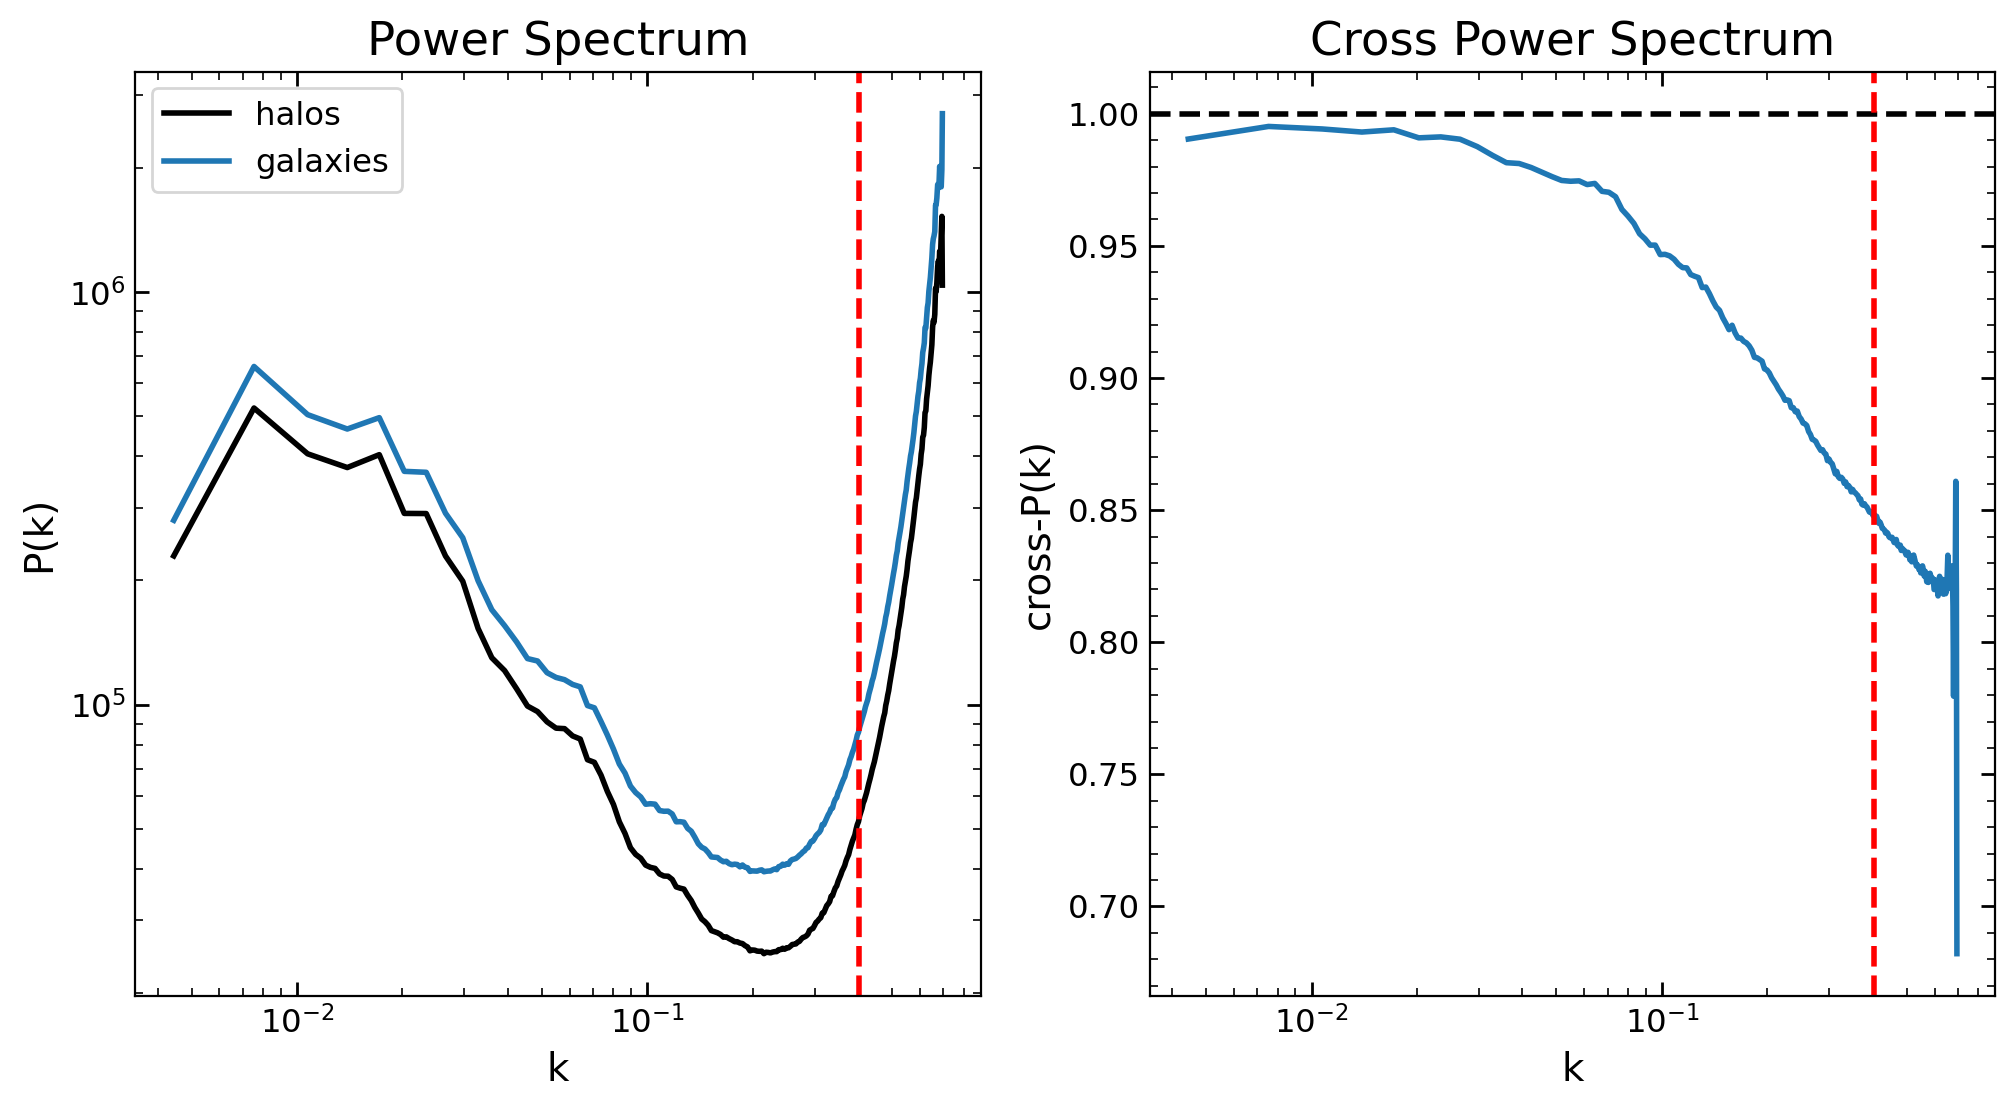

In [35]:
hx = (hhist/np.mean(hhist) - 1).astype(np.float32)
gx = (ghist/np.mean(ghist) - 1).astype(np.float32)
XPk = PKL.XPk([hx, gx], BoxSize=2000, axis=0, MAS=['CIC', 'CIC'], threads=1)

knyq = np.pi*256/2000

f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.plot(XPk.k3D, XPk.Pk[:, 0, 0], c='k', label='halos')
ax.plot(XPk.k3D, amu, label='galaxies')
ax.fill_between(XPk.k3D, amu-astd, amu+astd, alpha=0.3)
ax.axvline(knyq, color='r', ls='--')
ax.set(xlabel='k', ylabel='P(k)')
ax.legend()
ax.loglog()
ax.set_title('Power Spectrum')

ax = axs[1]
ax.axhline(1, color='k', ls='--')
ax.plot(XPk.k3D, bmu)
ax.fill_between(XPk.k3D, bmu-bstd, bmu+bstd, alpha=0.3)
ax.axvline(knyq, color='r', ls='--')
ax.semilogx()
ax.set(xlabel='k', ylabel='cross-P(k)')
ax.set_title('Cross Power Spectrum')


### Scanning HOD parameters

In [14]:
Nsamp = 10
minval, maxval = 13, 15
XPks = []

hx = (hhist/np.mean(hhist) - 1).astype(np.float32)
for i, r in enumerate(np.linspace(minval, maxval, Nsamp)):
    conf.bias.hod.theta.logMmin = float(r)

    hod = populate_hod(hpos, hvel, hmass, cosmo, conf, 0)

    gpos = np.array([hod['x'], hod['y'], hod['z']]).T
    ghist, edges = np.histogramdd(
        gpos, bins=[256]*3, 
        range=[(0, 2000)]*3)
    gx = (ghist/np.mean(ghist) - 1).astype(np.float32)
    XPk = PKL.XPk([hx, gx], BoxSize=2000, axis=0, MAS=['CIC', 'CIC'], threads=1)
    XPks.append(XPk)

NameError: name 'hhist' is not defined


Computing power spectra of the fields...
Time FFTS = 0.52
Time loop = 0.33
Time taken = 0.85 seconds


Text(0.5, 1.0, 'Cross Power Spectrum')

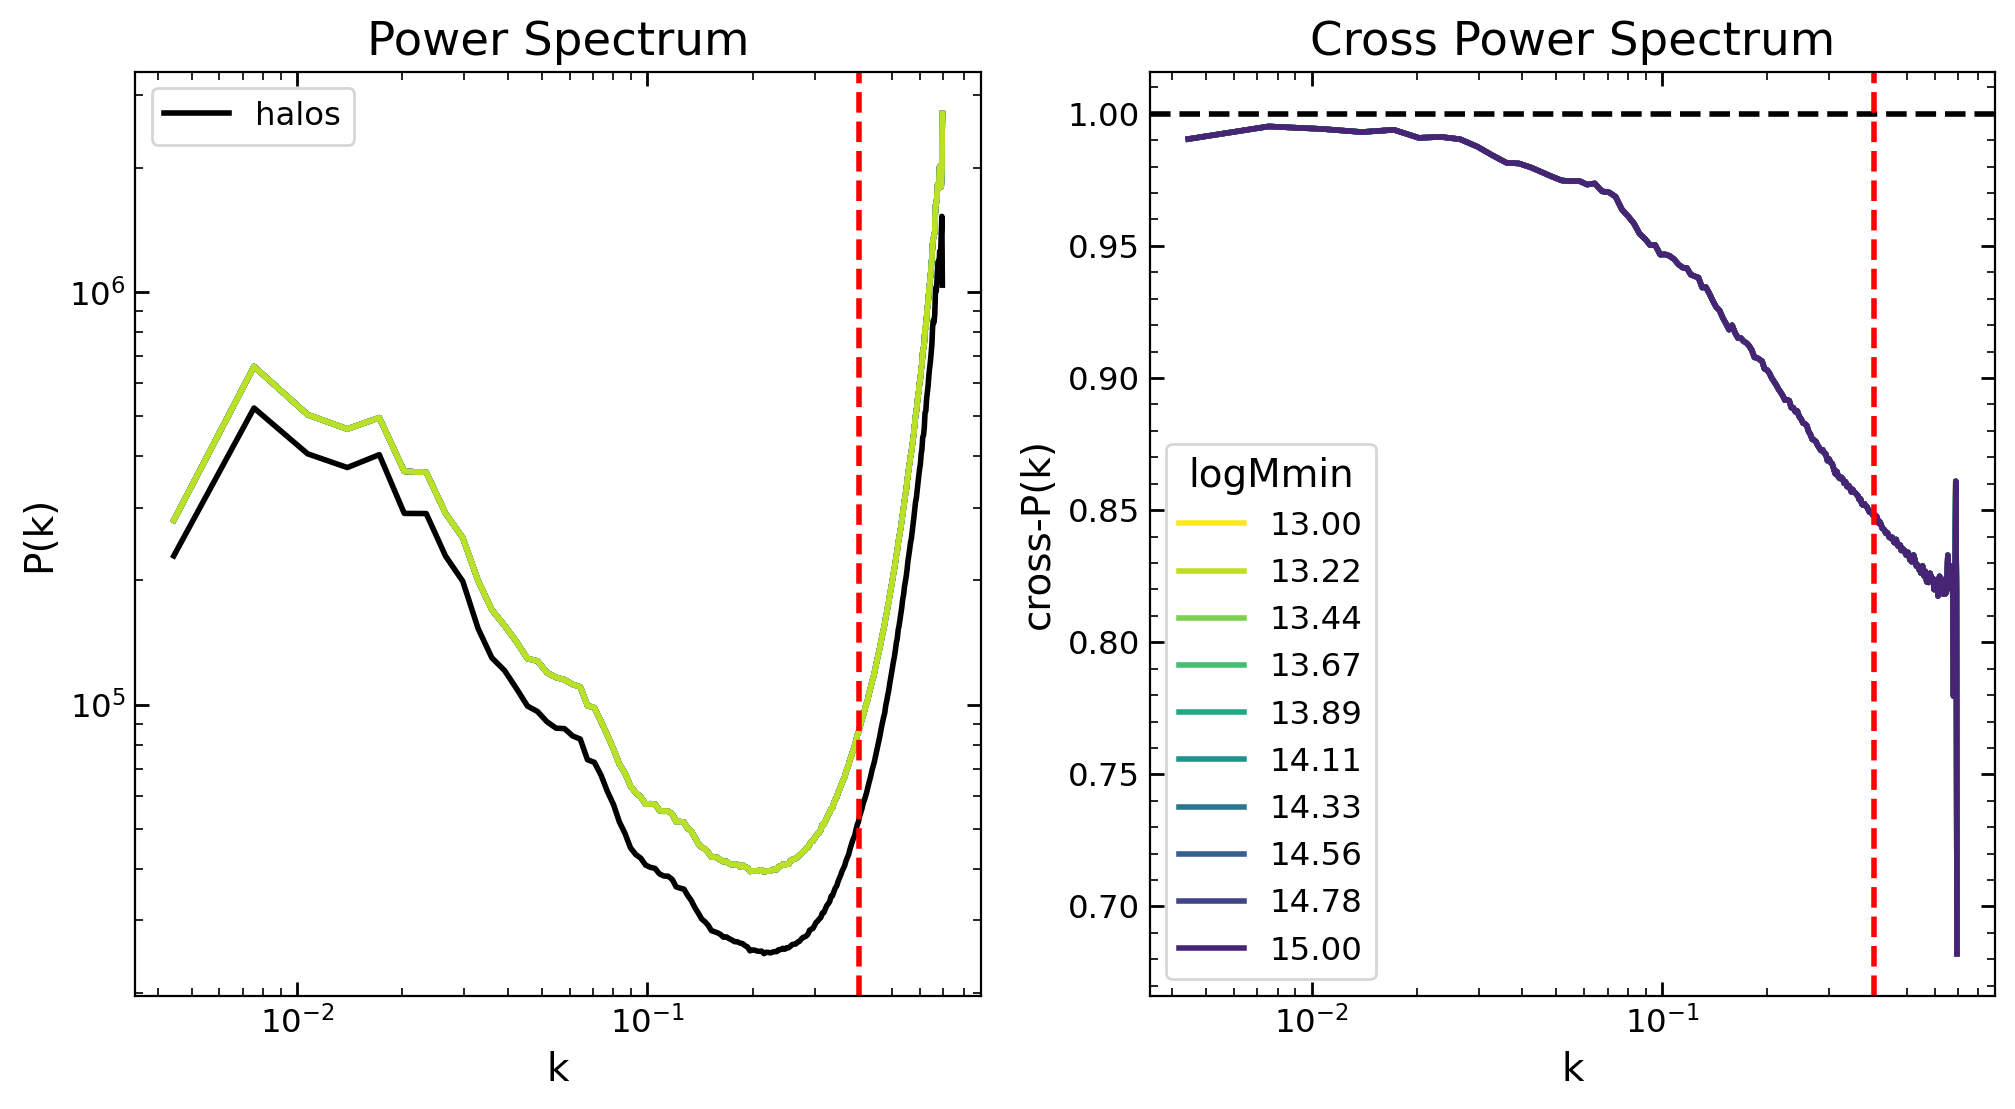

In [47]:
hx = (hhist/np.mean(hhist) - 1).astype(np.float32)
gx = (ghist/np.mean(ghist) - 1).astype(np.float32)
XPk = PKL.XPk([hx, gx], BoxSize=2000, axis=0, MAS=['CIC', 'CIC'], threads=1)

knyq = np.pi*256/2000
cmap = plt.get_cmap('viridis')

f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.plot(XPk.k3D, XPk.Pk[:, 0, 0], c='k', label='halos')
for i, XPk in enumerate(XPks):
    ax.plot(XPk.k3D, XPk.Pk[:, 0, 1], c=cmap(i/Nsamp))
ax.axvline(knyq, color='r', ls='--')
ax.set(xlabel='k', ylabel='P(k)')
ax.legend()
ax.loglog()
ax.set_title('Power Spectrum')

ax = axs[1]
ax.axhline(1, color='k', ls='--')
for i, XPk in enumerate(XPks):
    ax.plot(XPk.k3D, XPk.XPk[:,0,0]/np.sqrt((XPk.Pk[:, 0, 0]*XPk.Pk[:,0,1])), 
            c=cmap(1-i/Nsamp), label=f'{minval + i*(maxval-minval)/(Nsamp-1):.2f}')
ax.axvline(knyq, color='r', ls='--')
ax.semilogx()
ax.legend(title='logMmin')
ax.set(xlabel='k', ylabel='cross-P(k)')
ax.set_title('Cross Power Spectrum')


### Test Chris's implemenentation

[16:07:53-INFO] Running populate_hod...


{'logMmin': 13.10159580514915, 'sigma_logM': 0.4540739113090524, 'logM0': 13.581809477825889, 'logM1': 14.021655210395327, 'alpha': 1.3394204315214822, 'smhm_m0': 11.5}


[16:07:54-INFO] Finished populate_hod... (0m1s)


(518815, 3)


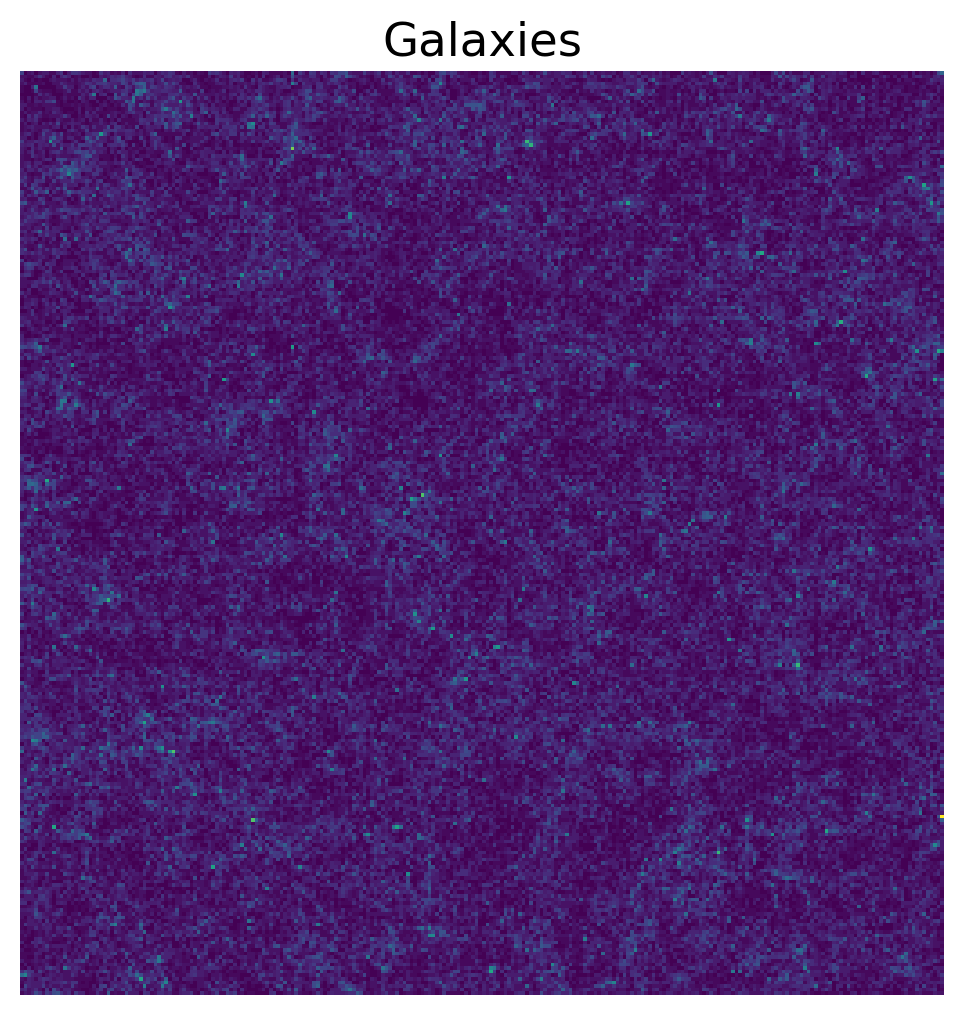

In [29]:
L = 2000
zf = 0.5
# model = 'leauthaud11'
theta = conf.bias.hod.theta
theta['smhm_m0'] = 11.5
print(theta)
hod = populate_hod(
    hpos, hvel, hmass,
    cosmo, L, zf,
    model, theta, 
    seed=0, mdef='vir'
)
gpos = np.array([hod['x'], hod['y'], hod['z']]).T
gvel = np.array([hod['vx'], hod['vy'], hod['vz']]).T
print(gpos.shape)

ghist, edges = np.histogramdd(
    gpos, bins=[256]*3, 
    range=[(0, 2000)]*3)

f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(ghist[:100].mean(axis=0), origin='lower')
ax.axis('off')
ax.set_title('Galaxies');

In [31]:
hod.dtype.names

('halo_rvir',
 'halo_y',
 'halo_hostid',
 'halo_x',
 'halo_upid',
 'halo_vx',
 'halo_vz',
 'halo_id',
 'halo_mvir',
 'halo_z',
 'conc_NFWmodel',
 'halo_vy',
 'halo_num_centrals',
 'halo_num_satellites',
 'gal_type',
 'x',
 'z',
 'y',
 'vz',
 'vy',
 'host_centric_distance',
 'vx')

In [15]:
upper = np.array([12.0, 0.1, 13.0, 13.0, 0.])
lower = np.array([14.0, 0.6, 15.0, 15.0, 1.5])
names = ['logMmin', 'sigma_logM', 'logM0', 'logM1', 'alpha']
Nsamp = 5

XPks = []
hhist, _ = np.histogramdd(
    hpos, bins=[256]*3, 
    range=[(0, 2000)]*3)
hx = (hhist/np.mean(hhist) - 1).astype(np.float32)
for i in range(len(upper)):
    print(i)
    values = np.linspace(lower[i], upper[i], Nsamp)
    iXPk = []
    for j in range(Nsamp):
        theta = deepcopy(conf.bias.hod.theta)
        theta[names[i]] = float(values[j])

        hod = populate_hod(
            hpos, hvel, hmass,
            cosmo, L, zf,
            model, theta, 
            seed=0, mdef='vir'
        )
        gpos = np.array([hod['x'], hod['y'], hod['z']]).T
        gvel = np.array([hod['vx'], hod['vy'], hod['vz']]).T

        ghist, edges = np.histogramdd(
            gpos, bins=[256]*3, 
            range=[(0, 2000)]*3)
        gx = (ghist/np.mean(ghist) - 1).astype(np.float32)
        XPk = PKL.XPk([hx, gx], BoxSize=2000, axis=0, MAS=['CIC', 'CIC'], threads=1)
        iXPk.append(XPk)
    XPks.append(iXPk)


[15:58:44-INFO] Running populate_hod...


0


[15:58:44-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.48


[15:58:45-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.82 seconds


[15:58:46-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.50


[15:58:47-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


[15:58:48-INFO] Finished populate_hod... (0m1s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:58:49-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.81 seconds


[15:58:50-INFO] Finished populate_hod... (0m1s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:58:51-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.80 seconds


[15:58:53-INFO] Finished populate_hod... (0m1s)



Computing power spectra of the fields...
Time FFTS = 0.51


[15:58:54-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds
1


[15:58:55-INFO] Finished populate_hod... (0m1s)



Computing power spectra of the fields...
Time FFTS = 0.48


[15:58:56-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.82 seconds


[15:58:57-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.51


[15:58:58-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


[15:58:59-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:00-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds


[15:59:01-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:01-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.80 seconds


[15:59:02-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:03-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.80 seconds
2


[15:59:04-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.51


[15:59:05-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


[15:59:06-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:07-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds


[15:59:08-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.51


[15:59:09-INFO] Running populate_hod...


Time loop = 0.34
Time taken = 0.85 seconds


[15:59:10-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:11-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.80 seconds


[15:59:12-INFO] Finished populate_hod... (0m1s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:13-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.80 seconds
3


[15:59:14-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:15-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds


[15:59:16-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.51


[15:59:17-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.84 seconds


[15:59:18-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:18-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds


[15:59:20-INFO] Finished populate_hod... (0m1s)



Computing power spectra of the fields...
Time FFTS = 0.48


[15:59:21-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds


[15:59:22-INFO] Finished populate_hod... (0m1s)



Computing power spectra of the fields...
Time FFTS = 0.48


[15:59:23-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds
4


[15:59:24-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:25-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds


[15:59:26-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.48


[15:59:27-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds


[15:59:28-INFO] Finished populate_hod... (0m0s)



Computing power spectra of the fields...
Time FFTS = 0.47


[15:59:29-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds


[15:59:30-INFO] Finished populate_hod... (0m1s)



Computing power spectra of the fields...
Time FFTS = 0.48


[15:59:31-INFO] Running populate_hod...


Time loop = 0.33
Time taken = 0.81 seconds


[15:59:32-INFO] Finished populate_hod... (0m1s)



Computing power spectra of the fields...
Time FFTS = 0.47
Time loop = 0.33
Time taken = 0.80 seconds


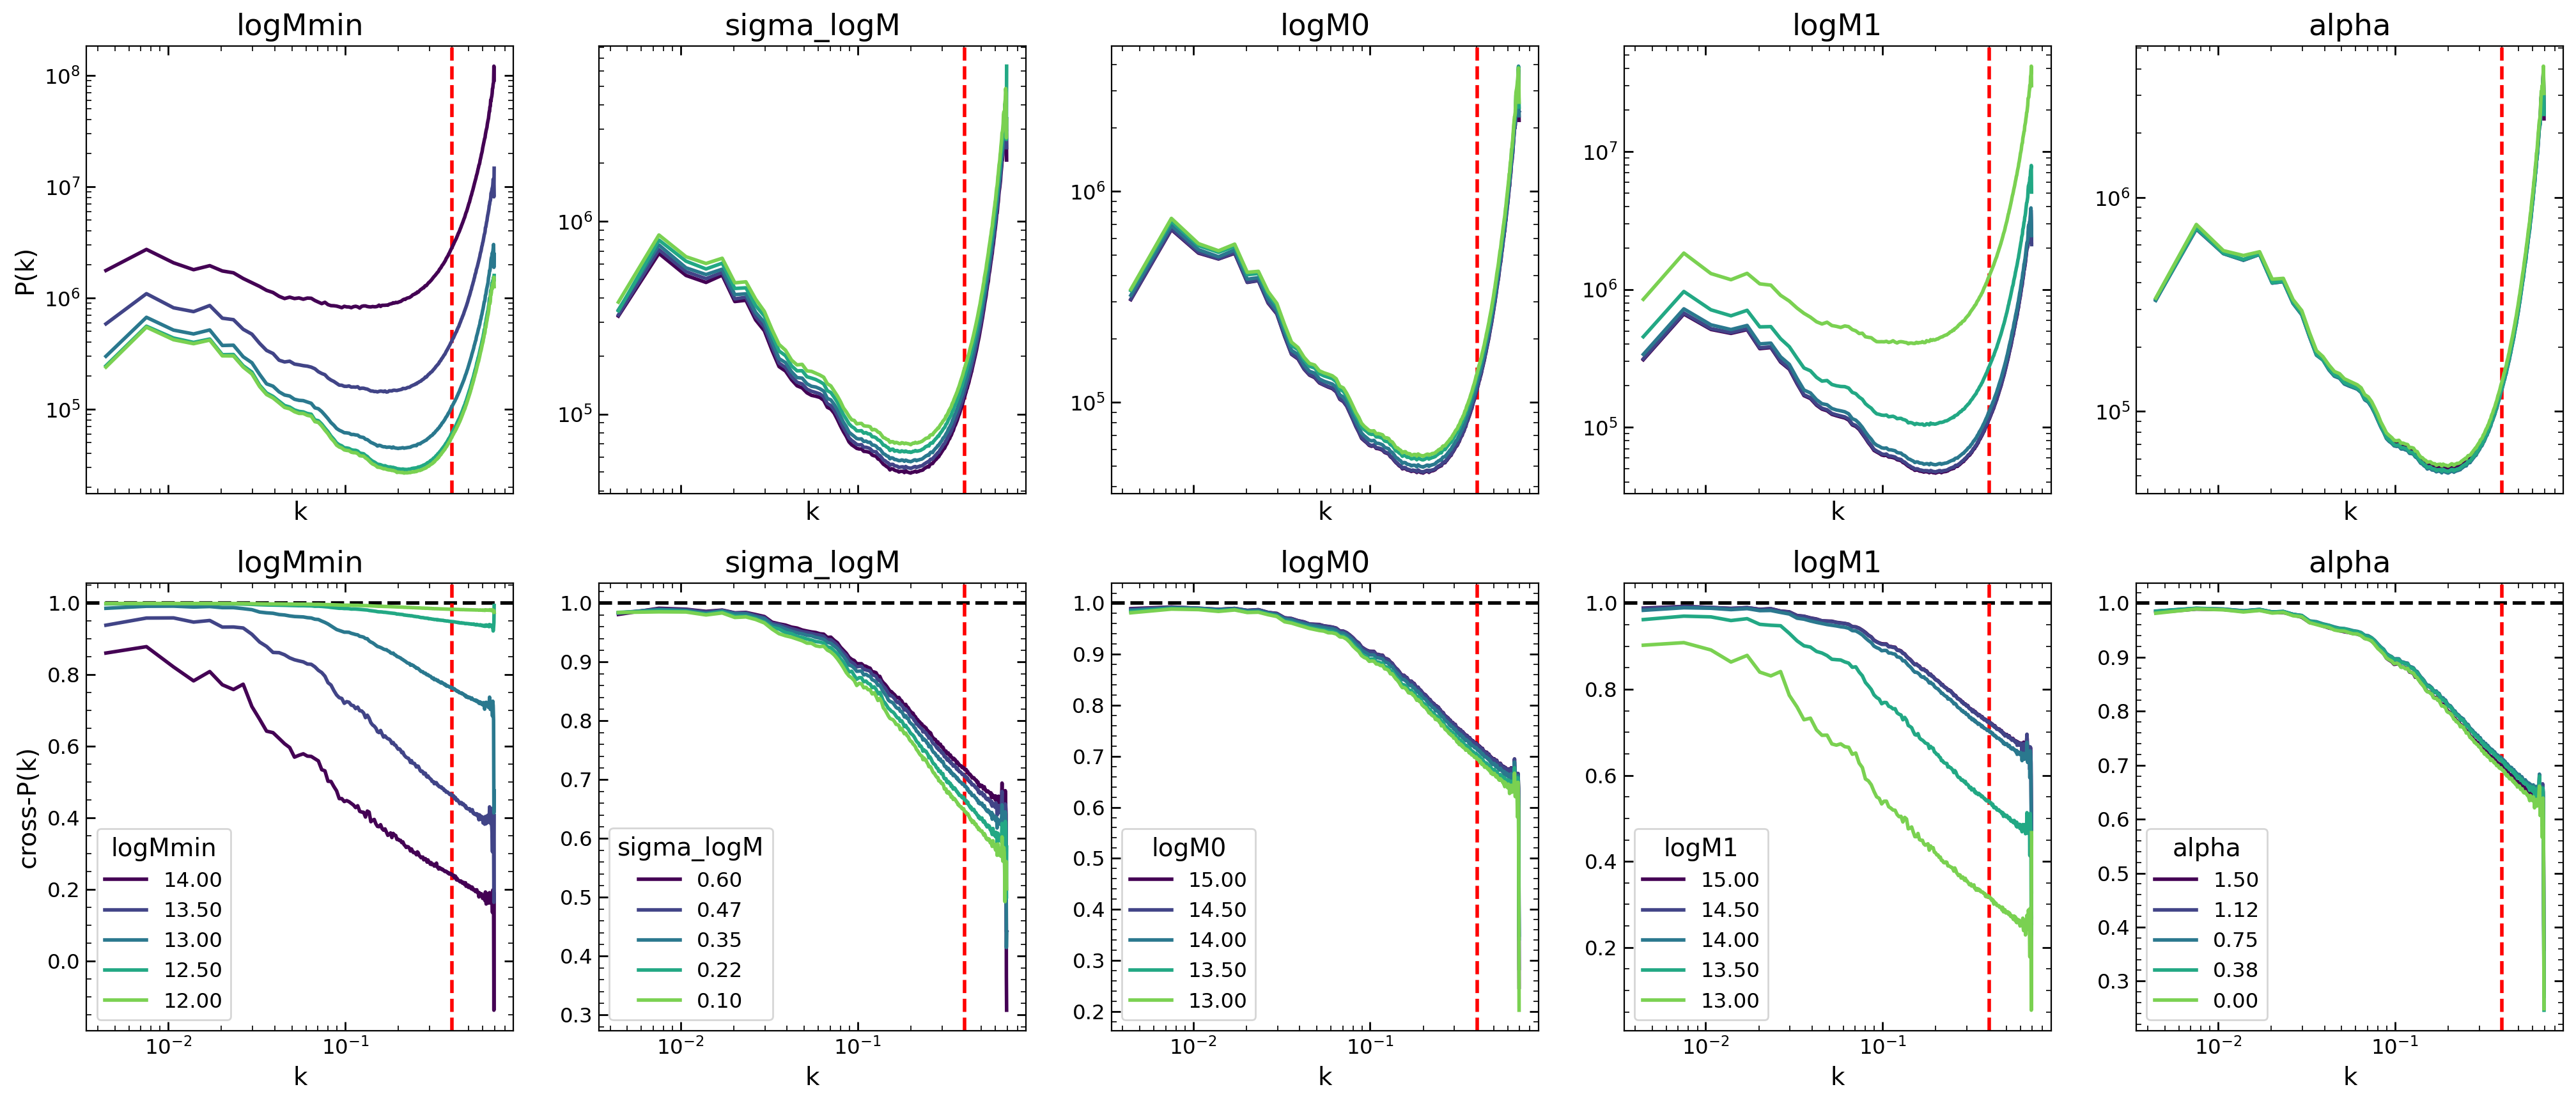

In [28]:
f, axs = plt.subplots(2, 5, figsize=(25, 10), sharex=True)

knyq = np.pi*256/2000
cmap = plt.get_cmap('viridis')
for i in range(len(upper)):
    values = np.linspace(lower[i], upper[i], Nsamp)
    ax = axs[0, i]
    ax.axvline(knyq, color='r', ls='--')
    for j in range(Nsamp):
        ax.plot(XPks[i][j].k3D, XPks[i][j].Pk[:, 0, 1], 
                c=cmap(j/Nsamp))
    ax.loglog()
    ax.set_xlabel('k')
    if i == 0:
        ax.set_ylabel('P(k)')
    ax.set_title(names[i])

    ax = axs[1, i]
    ax.axhline(1, color='k', ls='--')
    ax.axvline(knyq, color='r', ls='--')
    for j in range(Nsamp):
        ax.plot(XPks[i][j].k3D, XPks[i][j].XPk[:, 0, 0]/np.sqrt((XPks[i][j].Pk[:, 0, 0]*XPks[i][j].Pk[:,0,1])), 
                c=cmap(j/Nsamp),
                label=f'{values[j]:.2f}')
    ax.semilogx()
    ax.set_xlabel('k')
    if i == 0:
        ax.set_ylabel('cross-P(k)')
    ax.set_title(names[i])
    ax.legend(title=names[i])